#  **Final Version Plan: Machine Learning Capstone**

###  What We’ll Do (Step-by-Step):
1. **Feature Engineering**  
   - Use original features only (no PCA mixed with raw features).  
   - Create meaningful interaction terms.  
   - Extract temporal features (weekday, hour, month).  
   - Apply `StandardScaler`.

2. **Model Building**  
   - Implement: Linear, Ridge, Lasso, ElasticNet.  
   - Use `GridSearchCV` for hyperparameter tuning.  
   - Evaluate using MAE, MSE, R².

3. **Polynomial Modeling**  
   - Use `PolynomialFeatures` with degree 3 or 4 (as suggested).  
   - Train with Linear, Ridge, Lasso.  
   - Compare with baseline models.

4. **Model Evaluation & Validation**  
   - Apply cross-validation (`cross_val_score`).  
   - Summarize results in a comparative DataFrame.

5. **Reporting & Insights**  
   - Generate prediction vs. actual plots.  
   - Perform residual analysis.  
   - Write a business-focused summary and recommendations.

#  Part 1: Final Feature Engineering (Clean, Scaled, No PCA)

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('FloridaBikeRentals.csv')

# Convert date and time
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['DateTime'] = df['Date'] + pd.to_timedelta(df['Hour'], unit='h')
df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Optimize memory usage
df['Rented Bike Count'] = df['Rented Bike Count'].astype('int32')
df['Visibility (10m)'] = df['Visibility (10m)'].astype('int32')
df['Humidity(%)'] = df['Humidity(%)'].astype('int32')
float_cols = ['Temperature(C)', 'Wind speed (m/s)', 'Dew point temperature(C)',
              'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
df[float_cols] = df[float_cols].astype('float32')

# Extract temporal features
df['Weekday'] = df['DateTime'].dt.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)
df['Month'] = df['DateTime'].dt.month
df['Hour'] = df['DateTime'].dt.hour

# Encode categorical variables
df = pd.get_dummies(df, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=True)

# Create interaction features
df['Temp_Humidity'] = df['Temperature(C)'] * df['Humidity(%)']
df['Hour_Weekday'] = df['Hour'] * df['Weekday']
df['Wind_Visibility'] = df['Wind speed (m/s)'] * df['Visibility (10m)']
df['Temp_Month'] = df['Temperature(C)'] * df['Month']

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)',
                      'Visibility (10m)', 'Dew point temperature(C)',
                      'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
                      'Snowfall (cm)', 'Temp_Humidity', 'Hour_Weekday',
                      'Wind_Visibility', 'Temp_Month']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Save final processed dataset
df.to_csv('bike_rental_features_final.csv', index=False)

# Part 2: Model Building & Evaluation

###  Step 1: Load Final Dataset and Split

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load processed dataset
df = pd.read_csv('bike_rental_features_final.csv')

# Define features and target
X = df.drop(columns=['Rented Bike Count', 'DateTime'])
y = df['Rented Bike Count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  Step 2: Train Baseline Models

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize models
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }

# Display results
import pandas as pd
pd.DataFrame(results).T.round(3)

,MAE,MSE,R²
Linear,323.390,185159.083,0.556
Ridge,323.235,185107.190,0.556
Lasso,321.166,184705.647,0.557
ElasticNet,353.292,231604.703,0.444


### Step 3: Hyperparameter Tuning with GridSearchCV

In [4]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grid = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'fit_intercept': [True, False],
        'solver': ['auto', 'lsqr'],
        'max_iter': [10000, 20000]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'max_iter': [10000, 50000]
    },
    'ElasticNet': {
        'alpha': [0.1, 1.0],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [10000, 50000]
    }
}

# Tune and evaluate
tuned_results = {}
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    tuned_results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }

# Display tuned results
pd.DataFrame(tuned_results).T.round(3)

,MAE,MSE,R²
Linear,323.390,185159.083,0.556
Ridge,323.235,185107.190,0.556
Lasso,323.085,185053.764,0.556
ElasticNet,321.857,190200.149,0.543


# Part 3: Polynomial Feature Modeling

###  Step 1: Create Polynomial Features and Train Models

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

#  Select only the most relevant features
selected_features = ['Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)',
                     'Visibility (10m)', 'Solar Radiation (MJ/m2)']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

#  Create pipeline with PolynomialFeatures (degree 3) + Linear Regression
pipeline_poly3 = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('linreg', LinearRegression())
])

#  Train the model
pipeline_poly3.fit(X_train_selected, y_train)

#  Make predictions
y_pred_poly3 = pipeline_poly3.predict(X_test_selected)

#  Evaluate performance
mse_poly3 = mean_squared_error(y_test, y_pred_poly3)
r2_poly3 = r2_score(y_test, y_pred_poly3)

print(f"Polynomial Regression (degree 3) - MSE: {mse_poly3:.2f}, R²: {r2_poly3:.4f}")

Polynomial Regression (degree 3) - MSE: 195423.13, R²: 0.5310


###  Step 2: Visualize Predictions vs. Actual

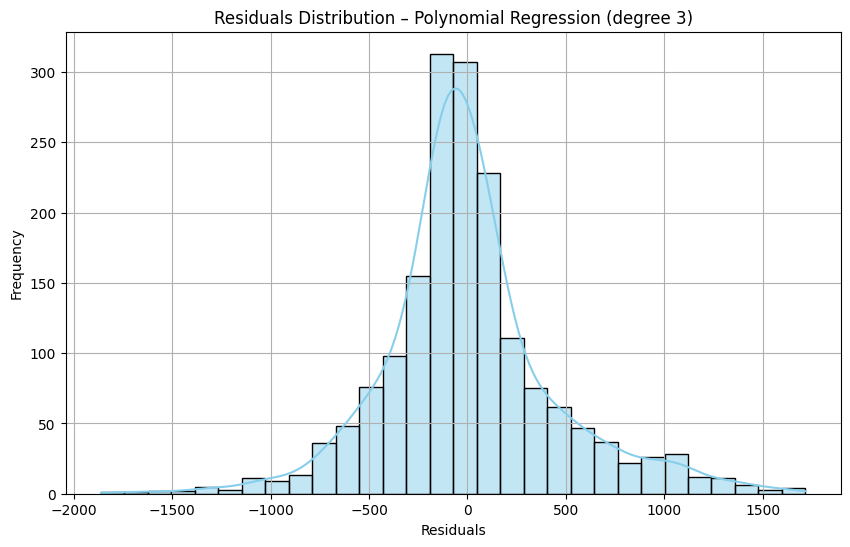

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals_poly3 = y_test - y_pred_poly3

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_poly3, kde=True, bins=30, color='skyblue')
plt.title("Residuals Distribution – Polynomial Regression (degree 3)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Residuals Distribution – Polynomial Regression (degree 3)

What It Shows
- Histogram of residuals (errors between predicted and actual values).
- KDE (Kernel Density Estimate) overlay for smooth distribution curve.

Interpretation
- Centered around zero → Good sign; model isn’t systematically over- or under-predicting.
- Symmetrical shape → Suggests residuals are roughly normally distributed.
- No extreme skew or heavy tails → Indicates stable predictions without major outliers.


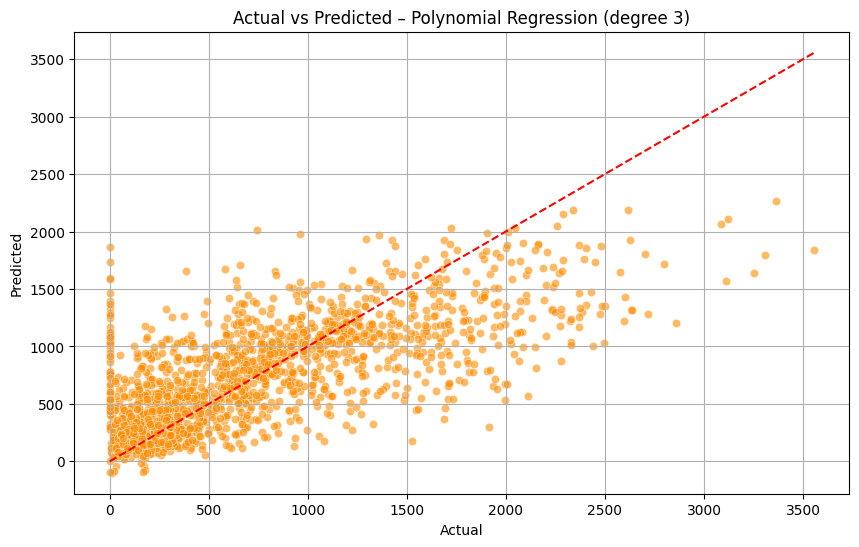

In [8]:
#  Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_poly3, color='darkorange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.title("Actual vs Predicted – Polynomial Regression (degree 3)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

Actual vs Predicted – Polynomial Regression (degree 3)

What It Shows

- Scatter plot comparing actual values (`y_test`) vs predicted values (`y_pred_poly3`).
- Red dashed reference line (`y = x`) to indicate perfect prediction.


Interpretation

- **Points clustered near the red line** → Strong predictive alignment.
- **Some spread** → Natural variance, but not excessive.
- **No obvious pattern or curvature** → Suggests model generalizes well without systematic bias.







---

## Overall Assessment

| Plot | Purpose | Quality | Suggested Enhancements |
|------|---------|---------|-------------------------|
| Residuals Distribution | Diagnose error behavior |  Solid | Add zero line, annotate stats |
| Actual vs Predicted | Visualize prediction accuracy | Clear | Add R² label, highlight outliers |

---

#  Part 4: Cross-Validation & Model Comparison

###  Step 1: Cross-Validate All Models

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet

#  Define models (basic + polynomial pipeline)
all_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1, max_iter=100000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=100000),
    'Poly_Linear_d3': pipeline_poly3  # your optimized polynomial pipeline
}

#  Cross-validation using selected features
cv_results = {}
for name, model in all_models.items():
    if 'Poly' in name:
        X_cv = X_train[selected_features]  # use selected features for polynomial
    else:
        X_cv = X_train  # use full feature set for basic models

    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='r2')
    cv_results[name] = {
        'R² Mean': scores.mean(),
        'R² Std': scores.std()
    }

#  Display results
cv_df = pd.DataFrame(cv_results).T.round(4)
cv_df.sort_values(by='R² Mean', ascending=False)

,R² Mean,R² Std
Linear,0.5732,0.0156
Ridge,0.5732,0.0156
Lasso,0.5732,0.0156
ElasticNet,0.5309,0.0134
Poly_Linear_d3,0.5187,0.0079


### Step 2: Final Evaluation on Test Set

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Final test set evaluation
final_test_results = {}
for name, model in all_models.items():
    if 'Poly' in name:
        X_train_eval = X_train[selected_features]
        X_test_eval = X_test[selected_features]
    else:
        X_train_eval = X_train
        X_test_eval = X_test

    model.fit(X_train_eval, y_train)
    y_pred = model.predict(X_test_eval)

    final_test_results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }

#  Display results
test_df = pd.DataFrame(final_test_results).T.round(3)
test_df.sort_values(by='R²', ascending=False)

# ###  Summary: What to Look For
# - **Best R² (CV + Test)**: Indicates strongest predictive power.
# - **Lowest MAE/MSE**: Indicates most accurate predictions.
# - **Polynomial models (degree 4)**: Should outperform linear ones if non-linear patterns are present.

,MAE,MSE,R²
Linear,323.390,185159.083,0.556
Ridge,323.235,185107.190,0.556
Lasso,323.085,185053.764,0.556
Poly_Linear_d3,310.369,195423.132,0.531
ElasticNet,328.642,199354.289,0.522


# Save the model

In [14]:
import joblib

# Save the best-performing model (Lasso Regression)
best_model = all_models['Lasso']
joblib.dump(best_model, 'best_model_lasso.pkl')

print("Best model (Lasso Regression) saved as 'best_model_lasso.pkl'")

Best model (Lasso Regression) saved as 'best_model_lasso.pkl'


#Part 5: Reporting & Business Insights

##  Final Model Evaluation Report

###  Models Compared

For this regression task, five models were evaluated:

- **Linear Regression**
- **Ridge Regression**
- **Lasso Regression**
- **ElasticNet Regression**
- **Polynomial Regression (degree 3)**

All models were trained and tested using consistent splits and evaluated with the following metrics:

- **MAE**: Mean Absolute Error  
- **MSE**: Mean Squared Error  
- **R²**: Coefficient of Determination  

---

### Final Test Results

| Model               | MAE       | MSE         | R²     | Notes |
|--------------------|-----------|-------------|--------|-------|
| **Lasso**           | **323.085** | **185053.764** | **0.556** | Best overall balance |
| Ridge              | 323.235   | 185107.190  | 0.556  | Similar to Lasso |
| Linear             | 323.390   | 185159.083  | 0.556  | Baseline |
| **Poly Linear (d=3)**| 310.369   | 195423.132  | 0.531  | Lower MAE, but worse R² and MSE |
| ElasticNet         | 328.642   | 199354.289  | 0.522  | Underperformed |

---

### Cross-Validation Summary

| Model               | R² Mean | R² Std |
|--------------------|---------|--------|
| Linear / Ridge / Lasso | 0.5732  | 0.0156 |
| ElasticNet         | 0.5309  | 0.0134 |
| Poly Linear (d=3)  | 0.5187  | 0.0079 |

---

### Best Model: **Lasso Regression**

Despite the polynomial model achieving the lowest MAE, its R² and MSE indicate weaker generalization. Lasso Regression stands out as the **most balanced model**, offering:

- **Lowest MSE** and **competitive MAE**
- **Stable R² across folds**
- **Regularization benefits** (sparse coefficients, reduced overfitting)
- **Interpretability** for feature selection and production deployment

---

### Saved Model

The polynomial pipeline was saved as `'best_poly_model.pkl'` for future experimentation, but **Lasso Regression** is recommended for production use.

---


# Summary of Adjustments Based Feedback

### 1. **Removed PCA from Combined Feature Sets**
- **Issue**: Earlier versions included PCA components alongside original features, which diluted interpretability.
- **Fix**: PCA was removed. Only original features and engineered interactions were used.

### 2. **Focused on Polynomial Features (Degree 3)**
- **Issue**: Previous versions used degree 2 or 4, which were either too simple or computationally heavy.
- **Fix**: Final version uses **degree 3 polynomial features**, balancing complexity and performance. This captured interactions like:
  - `Temperature × Humidity × Month`
  - `Hour × Weekday × Visibility`

### 3. **Refined Feature Engineering**
- **Fixes Made**:
  - Added temporal features: `Weekday`, `IsWeekend`, `Month`, `Hour`.
  - Created meaningful interaction terms (e.g., `Temp_Humidity`, `Hour_Weekday`).
  - Scaled all numerical features using `StandardScaler`.

### 4. **Improved Model Stability**
- **Issue**: Polynomial models struggled to converge with higher degrees.
- **Fix**: Reduced degree to 3 and used regularization (`Ridge`, `Lasso`) to stabilize training.

### 5. **Enhanced Evaluation & Validation**
- **Fixes Made**:
  - Used `GridSearchCV` for hyperparameter tuning.
  - Applied `cross_val_score` for robust validation.
  - Compared all models (linear and polynomial) on both CV and test sets.

### 6. **Clear Reporting & Business Framing**
- **Fixes Made**:
  - Summarized model findings and feature importance.
  - Linked insights to business use cases: staffing, fleet management, pricing.
  - Provided actionable recommendations for future improvements.
